In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pickle
import pandas as pd
import os

In [3]:
hbb = pd.read_parquet('parquet/no_subcut/hbb.parquet', engine='fastparquet')
hgg = pd.read_parquet('parquet/no_subcut/hgg.parquet', engine='fastparquet')

In [5]:
qcd = {}
files = os.listdir('parquet/no_subcut/')
for i in files:
    if 'qcd' in i:
        qcd[i.rstrip('.parquet')] = pd.read_parquet(f'parquet/no_subcut/{i}', engine='fastparquet')

In [6]:
qcd.keys()

dict_keys(['qcd_300to470', 'qcd_470to600', 'qcd_600to800', 'qcd_800to1000', 'qcd_1000to1400', 'qcd_1400to1800', 'qcd_1800to2400', 'qcd_2400to3200', 'qcd_3200toInf'])

In [7]:
vars = list(qcd['qcd_300to470'].keys())

In [8]:
IL = 44.99

In [9]:
xsec = {}
xsec['qcd_300to470'] = 6833
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [10]:
qcd_stitched_dict = {}
for j in vars:
    qcd_frac = {}
    for i in qcd:
        qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i][j])
    qcd_frac['tot'] = sum(qcd_frac.values())
    sval = {}
    for i in qcd:
        sval[i] = qcd_frac[i]/qcd_frac['tot']
    combed = {}
    for i in qcd:
        temp = qcd[i][j]
        combed[i] = temp[np.random.rand(temp.shape[0]) < sval[i]]
    stitched_var = np.concatenate([combed[x] for x in combed])
    qcd_stitched_dict[j] = stitched_var

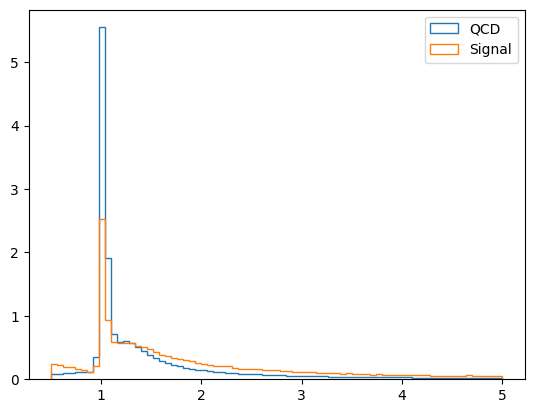

In [11]:
fig, ax = plt.subplots()
plt.hist(qcd_stitched_dict['FatJets.color_ring'], range=(.5,5), bins=75, density=True, histtype='step', label='QCD',#weights=21*np.ones_like(tst)
        )
plt.hist(hgg['FatJets.color_ring'], range=(.5,5), bins=75, density=True, histtype='step', label='Signal',#weights=21*np.ones_like(tst)
        )
plt.legend()
#plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

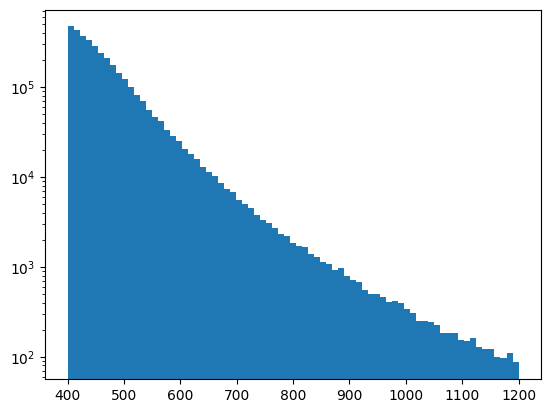

In [12]:
fig, ax = plt.subplots()
plt.hist(qcd_stitched_dict['FatJets.pt'], range=(400,1200), bins=75, #density=True, #weights=21*np.ones_like(tst)
        )
plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

In [13]:
hgg = hgg.reset_index(drop=True)

In [14]:
temp = hgg.to_dict('list')

In [15]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [16]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [17]:
hgg = pd.DataFrame.from_dict(nanless)

In [18]:
hbb = hbb.reset_index(drop=True)

In [19]:
temp = hbb.to_dict('list')

In [20]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [21]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [22]:
hbb = pd.DataFrame.from_dict(nanless)

In [23]:
nan_dict = {}
for i in qcd_stitched_dict:
    nan_mask = ~np.isnan(qcd_stitched_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = qcd_stitched_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [24]:
qcd = pd.DataFrame.from_dict(nanless)

In [25]:
hgg.to_parquet('parquet/no_subcut/combed/hgg.parquet')
hbb.to_parquet('parquet/no_subcut/combed/hbb.parquet')
qcd.to_parquet('parquet/no_subcut/combed/qcd.parquet')

In [26]:
ttboosted = {}
files = os.listdir('parquet/no_subcut')
for i in files:
    if 'ttboosted' in i:
        ttboosted[i.rstrip('.parquet')] = pd.read_parquet(f'parquet/no_subcut/{i}', engine='fastparquet')

In [27]:
vars = list(ttboosted['ttboosted_700to1000'].keys())

In [28]:
xsec = {}
xsec['ttboosted_700to1000'] = 64.35
xsec['ttboosted_1000toInf'] = 16.44

In [29]:
ttboosted_stitched_dict = {}
for j in vars:
    ttboosted_frac = {}
    for i in ttboosted:
        ttboosted_frac[i] = ((xsec[i]*1000)*IL)/len(ttboosted[i][j])
    ttboosted_frac['tot'] = sum(ttboosted_frac.values())
    sval = {}
    for i in ttboosted:
        sval[i] = ttboosted_frac[i]/ttboosted_frac['tot']
    combed = {}
    for i in ttboosted:
        temp = ttboosted[i][j]
        combed[i] = temp[np.random.rand(temp.shape[0]) < sval[i]]
    stitched_var = np.concatenate([combed[x] for x in combed])
    ttboosted_stitched_dict[j] = stitched_var

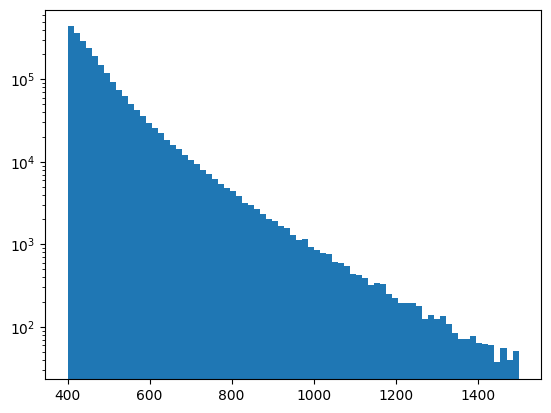

In [30]:
fig, ax = plt.subplots()
plt.hist(ttboosted_stitched_dict['FatJets.pt'], range=(400,1500), bins=75, #density=True, #weights=21*np.ones_like(tst)
        )
plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

In [31]:
nan_dict = {}
for i in ttboosted_stitched_dict:
    nan_mask = ~np.isnan(ttboosted_stitched_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in ttboosted_stitched_dict:
    nanless[i] = ttboosted_stitched_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [32]:
ttboosted = pd.DataFrame.from_dict(nanless)

In [34]:
ttboosted.to_parquet('parquet/no_subcut/combed/ttboosted.parquet')

In [41]:
wqq = {}
files = os.listdir('parquet/no_subcut')
for i in files:
    if 'wqq' in i:
        wqq[i.rstrip('.parquet')] = pd.read_parquet(f'parquet/no_subcut/{i}', engine='fastparquet')

In [43]:
vars = list(wqq['wqq_600to800'].keys())

In [44]:
xsec = {}
xsec['wqq_200to400'] = 2574
xsec['wqq_400to600'] = 276.2
xsec['wqq_600to800'] = 58.9
xsec['wqq_800toInf'] = 28.93

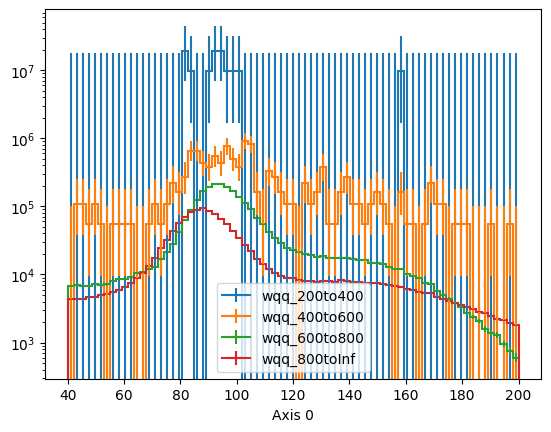

In [45]:
import hist
h = hist.Hist.new.Reg(75, 40, 200).StrCat(list(wqq), name="name").Weight()
for name, samp in wqq.items():
    h.fill(samp["FatJets.msoftdrop"], name, weight=xsec[name]*1000*IL/len(samp))

fig, ax = plt.subplots()
h.plot1d(ax=ax, overlay="name")
ax.set_yscale("log")
ax.legend()

In [46]:
del wqq['wqq_200to400']

In [47]:
del wqq['wqq_400to600']

In [48]:
wqq_stitched_dict = {}
for j in vars:
    wqq_frac = {}
    for i in wqq:
        wqq_frac[i] = ((xsec[i]*1000)*IL)/len(wqq[i][j])
    wqq_frac['tot'] = sum(wqq_frac.values())
    sval = {}
    for i in wqq:
        sval[i] = wqq_frac[i]/wqq_frac['tot']
    combed = {}
    for i in wqq:
        temp = wqq[i][j]
        combed[i] = temp[np.random.rand(temp.shape[0]) < sval[i]]
    stitched_var = np.concatenate([combed[x] for x in combed])
    wqq_stitched_dict[j] = stitched_var

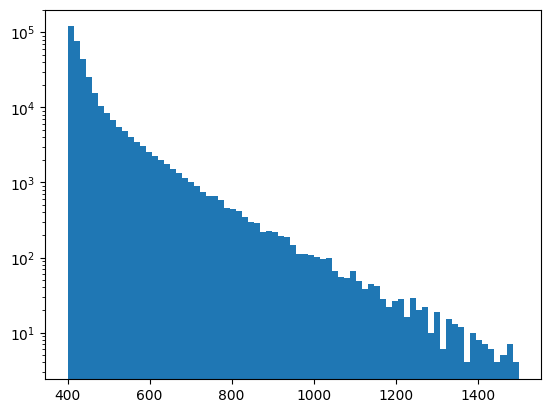

In [49]:
fig, ax = plt.subplots()
plt.hist(wqq_stitched_dict['FatJets.pt'], range=(400,1500), bins=75, #density=True, #weights=21*np.ones_like(tst)
        )
plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

In [50]:
nan_dict = {}
for i in wqq_stitched_dict:
    nan_mask = ~np.isnan(wqq_stitched_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in wqq_stitched_dict:
    nanless[i] = wqq_stitched_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [51]:
wqq = pd.DataFrame.from_dict(nanless)

In [52]:
wqq.to_parquet('parquet/no_subcut/combed/wqq.parquet')

In [59]:
zqq = {}
files = os.listdir('parquet/no_subcut')
for i in files:
    if 'zqq' in i:
        zqq[i.rstrip('.parquet')] = pd.read_parquet(f'parquet/no_subcut/{i}', engine='fastparquet')

In [60]:
vars = list(zqq['zqq_600to800'].keys())

In [61]:
xsec = {}
xsec['zqq_200to400'] = 1006
xsec['zqq_400to600'] = 114.3
xsec['zqq_600to800'] = 25.19
xsec['zqq_800toInf'] = 12.9

In [62]:
del zqq['zqq_200to400']
del zqq['zqq_400to600']

In [63]:
zqq_stitched_dict = {}
for j in vars:
    zqq_frac = {}
    for i in zqq:
        zqq_frac[i] = ((xsec[i]*1000)*IL)/len(zqq[i][j])
    zqq_frac['tot'] = sum(zqq_frac.values())
    sval = {}
    for i in zqq:
        sval[i] = zqq_frac[i]/zqq_frac['tot']
    combed = {}
    for i in zqq:
        temp = zqq[i][j]
        combed[i] = temp[np.random.rand(temp.shape[0]) < sval[i]]
    stitched_var = np.concatenate([combed[x] for x in combed])
    zqq_stitched_dict[j] = stitched_var

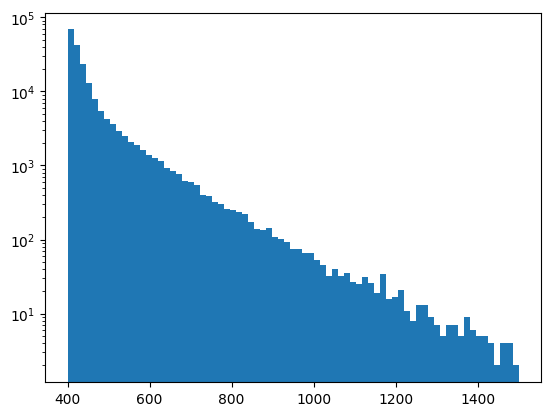

In [65]:
fig, ax = plt.subplots()
plt.hist(zqq_stitched_dict['FatJets.pt'], range=(400,1500), bins=75, #density=True, #weights=21*np.ones_like(tst)
        )
plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

In [66]:
nan_dict = {}
for i in zqq_stitched_dict:
    nan_mask = ~np.isnan(zqq_stitched_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in zqq_stitched_dict:
    nanless[i] = zqq_stitched_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [67]:
zqq = pd.DataFrame.from_dict(nanless)

In [69]:
zqq.to_parquet('parquet/no_subcut/combed/zqq.parquet')

In [72]:
singletop = pd.read_parquet('parquet/no_subcut/singletop.parquet', engine='fastparquet')

In [73]:
singletop = singletop.reset_index(drop=True)

In [74]:
temp = singletop.to_dict('list')

In [75]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [76]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [77]:
singletop = pd.DataFrame.from_dict(nanless)

In [78]:
singletop.to_parquet('parquet/no_subcut/combed/singletop.parquet')

In [79]:
ww = pd.read_parquet('parquet/no_subcut/ww.parquet', engine='fastparquet')

In [80]:
ww = ww.reset_index(drop=True)

In [81]:
temp = ww.to_dict('list')

In [82]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [83]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [84]:
ww = pd.DataFrame.from_dict(nanless)

In [85]:
ww.to_parquet('parquet/no_subcut/combed/ww.parquet')

In [86]:
wz = pd.read_parquet('parquet/no_subcut/wz.parquet', engine='fastparquet')

In [87]:
wz = wz.reset_index(drop=True)

In [88]:
temp = wz.to_dict('list')

In [89]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [90]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [91]:
wz = pd.DataFrame.from_dict(nanless)

In [92]:
wz.to_parquet('parquet/no_subcut/combed/wz.parquet')

In [93]:
zz = pd.read_parquet('parquet/no_subcut/zz.parquet', engine='fastparquet')

In [94]:
zz = zz.reset_index(drop=True)

In [95]:
temp = zz.to_dict('list')

In [96]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [97]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in qcd_stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [98]:
zz = pd.DataFrame.from_dict(nanless)

In [99]:
zz.to_parquet('parquet/no_subcut/combed/zz.parquet')